<a href="https://colab.research.google.com/github/thefil9/AIProject/blob/master/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tytuł projektu

Dane pobrałem stąd - https://www.kaggle.com/orgesleka/used-cars-database . Są to ogłoszenia o sprzedaży samochodów z niemieckiego serwisu Ebay, zebrane w roku 2016. Na ich podstawie postaram się wyestymować cenę samochodu w zależności od jego parametrów, takich jak moc oraz licznik kilometrów,


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#autos = pd.read_csv('autos.csv', encoding='cp1252')
autos = pd.read_csv('/content/drive/My Drive/Colab Notebooks/autos.csv', encoding='cp1252')

In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-nu

In [4]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Jak widać, mamy sporo kolumn, z czego nie wszystkie nas interesują, część ma też puste wartości.
Zajmijmy się wstępną obróbką danych. Najpierw zdecydujemy, jakie kolumny mogą zawierać wartościowe informacje. Kolumna name nie jest interesująca - jest to po prostu tytuł ogłoszenia. Wszystkie potrzebne informacje o autach są zawarte w innych kolumnach. Kolumna seller zawiera informacje o tym, czy sprzedawcą jest osoba prywatna, czy dealer, też jest nieistotna. Usuniemy też kolumny z datą stworzenia ogłoszenia, liczbą zdjęć, kodem pocztowym, ostatnim momentem, kiedy ogłoszenie było widoczne, miesiącem rejestracji (zostawimy rok).

In [0]:
autos = autos.drop(columns = ['dateCrawled', 'name', 'seller', 'monthOfRegistration', 'dateCreated', 'nrOfPictures', 'postalCode', 'lastSeen'])

Kolumna offerType zawiera tylko dwie wartości, z czego druga występuje bardzo rzadko. Nie wniesie żadnych informacji, więc ją usuniemy.

In [0]:
autos['offerType'].value_counts()
autos = autos.drop(columns = ['offerType'])

Załóżmy, że powypadkowe samochody nas nie iteresują. W takim razie, usuńmy wszystkie auta, które mają jakieś nienaprawione uszkodzenia.

In [0]:
autos = autos[autos['notRepairedDamage'] != 'ja']

Odfiltrujmy wartości, które na pewno nie są poprawne, np. samochody zarejestrowane w 1200 roku.

In [8]:
autos['yearOfRegistration'].unique()

array([1993, 2004, 2001, 2008, 1980, 2014, 1998, 1995, 2011, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 2017, 1981, 2003, 1994, 1991, 1984,
       1990, 2006, 1999, 2012, 2005, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1968, 1982, 1976, 1983, 1959, 1973, 1111, 1969, 1971,
       1987, 1986, 1988, 1967, 1970, 1965, 1945, 1925, 1974, 1979, 1955,
       1978, 1972, 1977, 1961, 1963, 1964, 1960, 1966, 1975, 1937, 1936,
       5000, 1954, 1958, 9999, 1956, 3200, 1000, 1933, 1941, 1962, 8888,
       1500, 2200, 4100, 1929, 1951, 1957, 1940, 3000, 2066, 1949, 2019,
       1800, 1953, 1935, 1234, 8000, 5300, 2900, 6000, 5900, 5911, 1400,
       1950, 4000, 1948, 1952, 1200, 8500, 1932, 1255, 1927, 1923, 3700,
       3800, 4800, 1942, 7000, 1911, 6500, 9000, 2290, 2500, 1930, 1001,
       6200, 9450, 1944, 1943, 1947, 1934, 1938, 1688, 2800, 1253, 1928,
       1931, 7500, 5555, 7777, 5600, 1600, 2222, 1039, 9996, 1300, 8455,
       1915, 4500, 1920, 1939, 7800, 9229, 1946, 71

In [0]:
autos = autos[autos['yearOfRegistration'].between(1950, 2016)]
autos = autos[autos['price'].between(200, 75000)]
autos = autos[autos['powerPS'].between(30, 800)]
autos = autos[autos['kilometer'].between(1000, 400000)]

Teraz zobaczmy, czy mamy jakieś brakujące dane.

In [10]:
autos.isnull().sum()

price                     0
abtest                    0
vehicleType            9084
yearOfRegistration        0
gearbox                4622
powerPS                   0
model                  9744
kilometer                 0
fuelType              12894
brand                     0
notRepairedDamage     41985
dtype: int64

Jak widać, 5 kolumn ma brakujące dane. Możemy albo usunąć te wiersze, albo uzupełnić je innymi danymi. Ewentualnie usunąć całą kolumnę, co zrobię z kolumną notRepairedDamage ( już i tak uzyskaliśmy potrzebne z niej informacje). 

In [0]:
autos = autos.drop(columns = ['notRepairedDamage'])

W przypadku skrzyni biegów, możemy uzupełnić wartości skojarzone z marką auta ( to pole nie zawiera żadnych pustych wartości). To samo zrobimy z typem paliwa.

In [0]:
def fill_values (column_in, column_out, fill_null):
    val_dict = { 'brand_name' : ('gear_type', 1)}

    for (brand_name, gear_type), gear_count in autos.groupby(column_in)[column_out].value_counts().items():
        if brand_name in val_dict :
            if gear_count > val_dict[brand_name][1] :
                val_dict[brand_name] = (gear_type, gear_count)
        else:
            val_dict[brand_name] = (gear_type, gear_count)

    for brand_name in val_dict:
        if fill_null:
            autos.loc[(autos[column_in] == brand_name) & (autos[column_out].isnull()), column_out] = val_dict[brand_name][0] 
        else:
            autos.loc[(autos[column_in] == brand_name) & (autos[column_out] == 0), column_out] = val_dict[brand_name][0] 

fill_values('brand', 'gearbox', True)

fill_values('brand', 'fuelType', True)

Następnie usuniemy wszystkie modele, które nie istnieją, a potem uzupełnimy wartości kolumny vehicleType skojarzone z nazwą modelu.

In [0]:
autos = autos[autos['model'].notnull()]

In [0]:
fill_values('model', 'vehicleType', True)

Jak widać, nasze dane nie zawierają żadnych pustych pól. Warto też zobaczyć, w jakim stanie aktualnie jest nasz data frame.

In [15]:
print(autos.isnull().sum())
autos.head()

price                 0
abtest                0
vehicleType           0
yearOfRegistration    0
gearbox               0
powerPS               0
model                 0
kilometer             0
fuelType              0
brand                 0
dtype: int64


,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
2,9800,test,suv,2004,automatik,163,grand,125000,diesel,jeep
3,1500,test,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
4,3600,test,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda
6,2200,test,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot
8,14500,control,bus,2014,manuell,125,c_max,30000,benzin,ford


Nie przejmujemy się też tym, czy oferta była wystawion jako abtest. Dodatkowo, uzupełnijmy też wartości kolumny powerPS w miejscach, gdzie jest równa 0 - cena będzie zależna od mocy.

In [0]:
autos = autos.drop(columns = ['abtest'])

In [0]:
fill_values('model', 'powerPS', False)

In [18]:
autos.head()

,price,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,fuelType,brand
2,9800,suv,2004,automatik,163,grand,125000,diesel,jeep
3,1500,kleinwagen,2001,manuell,75,golf,150000,benzin,volkswagen
4,3600,kleinwagen,2008,manuell,69,fabia,90000,diesel,skoda
6,2200,cabrio,2004,manuell,109,2_reihe,150000,benzin,peugeot
8,14500,bus,2014,manuell,125,c_max,30000,benzin,ford


Ostatnią rzeczą jaką wykonamy, jest zamienieni wszystkich kolumn z liczbami na typ numeryczny ( ponieważ niektóre są typu object) oraz zamiana kolumn z dwoma wartościami na 0 oraz 1 (czyli gearbox).

In [0]:
autos['powerPS'] = pd.to_numeric(autos['powerPS'])
autos.loc[autos['gearbox'] == 'manuell', 'gearbox'] = 0
autos.loc[autos['gearbox'] == 'automatik', 'gearbox'] = 1
autos['gearbox'] = pd.to_numeric(autos['gearbox'])

Teraz możemy sobie zwizualizować różne zależności. Zobaczmy najpierw, czy są jakieś koleracje między danymi.

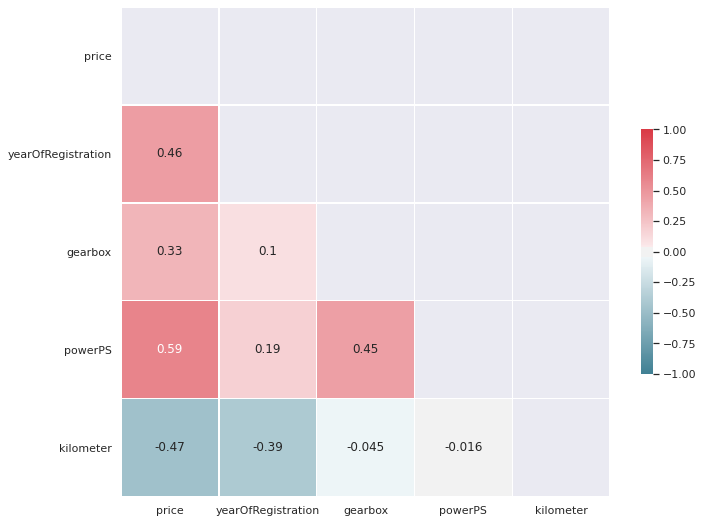

,price,yearOfRegistration,gearbox,powerPS,kilometer
price,1.000000,0.457560,0.329966,0.594244,-0.466404
yearOfRegistration,0.457560,1.000000,0.102811,0.186749,-0.392466
gearbox,0.329966,0.102811,1.000000,0.453097,-0.045247
powerPS,0.594244,0.186749,0.453097,1.000000,-0.015508
kilometer,-0.466404,-0.392466,-0.045247,-0.015508,1.000000


In [20]:
sns.set(style="darkgrid")

corr = autos.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax, annot=True)
plt.show()
corr

Jak widać, jakieś są, szczególnie, po oczyszczeniu danych ( przed były bliskie zeru). Największa koleracja (pozytywna) występuje pomiędzy ceną, a mocą auta, a największa (negatywna) między ceną, a przebiegiem.

In [21]:
autos.describe()

,price,yearOfRegistration,gearbox,powerPS,kilometer
count,270425.000000,270425.000000,270425.000000,270425.000000,270425.000000
mean,6605.044419,2003.570931,0.230696,127.871121,124360.894888
std,7609.682312,6.516198,0.421279,61.161495,39620.099580
min,200.000000,1950.000000,0.000000,30.000000,5000.000000
25%,1690.000000,2000.000000,0.000000,82.000000,100000.000000
50%,3950.000000,2004.000000,0.000000,116.000000,150000.000000
75%,8699.000000,2008.000000,0.000000,151.000000,150000.000000
max,75000.000000,2016.000000,1.000000,776.000000,150000.000000


Teraz, podzielimy dane na zestaw treningowy i testowy. Niestety, musiałem bardzo obciąć zbiór, bo nie starczało mi pamięci.

In [0]:
temp, temp2 = train_test_split(autos, test_size=0.9)
temp = temp.drop(columns = ['vehicleType','gearbox', 'fuelType', 'brand', 'model'])
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
temp[['price', 'yearOfRegistration', 'powerPS','kilometer']] = scaler.fit_transform(temp[['price', 'yearOfRegistration', 'powerPS','kilometer']])
autos_train, autos_test = train_test_split(temp, test_size=0.5)

In [23]:
temp

,price,yearOfRegistration,powerPS,kilometer
247960,0.024083,0.757576,0.119279,1.000000
80375,0.009357,0.681818,0.083218,0.827586
132950,0.027443,0.757576,0.119279,1.000000
343650,0.370817,0.969697,0.277393,0.241379
333189,0.110442,0.848485,0.199723,1.000000
...,...,...,...,...
283517,0.039491,0.818182,0.119279,1.000000
63726,0.113119,0.878788,0.180305,1.000000
264004,0.242972,0.878788,0.099861,1.000000
298622,0.021406,0.757576,0.110957,1.000000


In [24]:
#https://stackoverflow.com/a/40005797
autos_train['single_input_vector'] = autos_train[['yearOfRegistration','powerPS', 'kilometer']].apply(tuple, axis=1).apply(list)
autos_train['single_input_vector'] = autos_train.single_input_vector.apply(lambda x: [list(x)])
autos_train['cumulative_input_vectors'] = autos_train.single_input_vector.cumsum()
autos_train['output_vector'] = autos_train[['price']].apply(tuple, axis=1).apply(list)
X_train_init = np.asarray(autos_train[['yearOfRegistration','powerPS', 'kilometer']])
X_train = np.hstack(X_train_init).reshape(len(autos_train),1, 3)
y_train = np.hstack(np.asarray(autos_train.output_vector)).reshape(len(autos_train),1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Zróbmy sobie pierwszy model RNN

In [25]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

# Build the model
model = Sequential()

input_length = X_train.shape[1]
input_dim = X_train.shape[2]
# Output dimensions is the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])

model.add(LSTM(4, input_dim = input_dim, input_length = input_length))
model.add(Dense(output_dim, activation='relu'))



model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, input_shape=(1, 3))`
  del sys.path[0]


In [26]:
history = model.fit(X_train, y_train,
              batch_size=100, nb_epoch=200,
              verbose = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/200
13521/13521 [==============================] - 1s 38us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 2/200
13521/13521 [==============================] - 0s 17us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 3/200
13521/13521 [==============================] - 0s 17us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 4/200
13521/13521 [==============================] - 0s 19us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 5/200
13521/13521 [==============================] - 0s 18us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 6/200
13521/13521 [==============================] - 0s 18us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 7/200
13521/13521 [==============================] - 0s 18us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 8/200
13521/13521 [==============================] - 0s 18us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 9/200
13521/13521 [==============================] - 0s 18us/step - loss: 0.0181 - accuracy: 0.0030
Epoch 10/200
13521/13521 [====================

In [27]:
autos_test['single_input_vector'] = autos_test[['yearOfRegistration','powerPS', 'kilometer']].apply(tuple, axis=1).apply(list)
autos_test['single_input_vector'] = autos_test.single_input_vector.apply(lambda x: [list(x)])
autos_test['cumulative_input_vectors'] = autos_test.single_input_vector.cumsum()
X_train_init1 = np.asarray(autos_test[['yearOfRegistration','powerPS', 'kilometer']])
X_test = np.hstack(X_train_init1).reshape(len(autos_train),1,3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

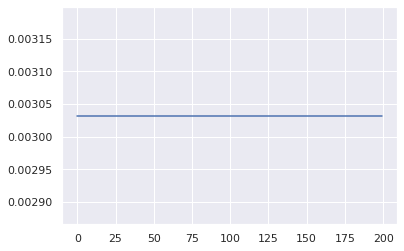

In [28]:
plt.plot(history.history['accuracy'])
plt.show()

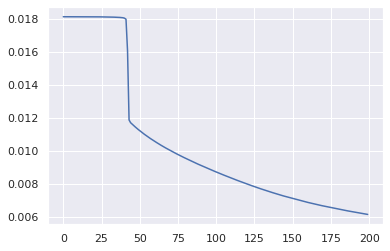

In [29]:
plt.plot(history.history['loss'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2704)              10816     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                135250    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 146,587
Trainable params: 146,587
Non-trainable params: 0
_________________________________________________________________
Train on 13521 samples, validate on 13521 samples
Epoch 1/100
13521/13521 [==============================] - 3s 199us/step - loss: 0.2990 - accuracy: 0.0030 - val_loss: 0.2935 - val_accuracy: 0.0037
Epoch 2/100
13521/13521 [======================

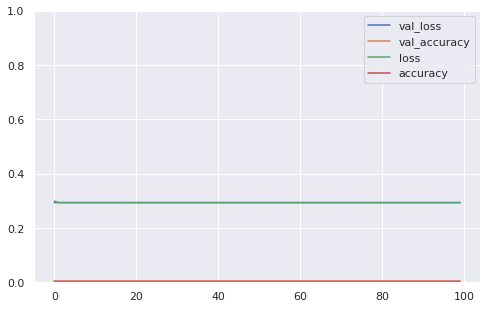

13521/13521 [==============================] - 1s 40us/step


[0.2937446138547745, 0.0036979513242840767]

In [30]:

X_train = np.hstack(X_train_init).reshape(len(autos_train), 3)
X_test = np.hstack(X_train_init1).reshape(len(autos_train),3)
autos_test['output_vector'] = autos_test[['price']].apply(tuple, axis=1).apply(list)
y_test = np.hstack(np.asarray(autos_test.output_vector)).reshape(len(autos_test),1)

from keras.callbacks import History

history = History()
model = Sequential()
model.add(Dense(2704,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()
model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100)
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
model.evaluate(X_test,y_test)

In [31]:
model.predict(X_test)

array([[0.09197891],
       [0.09197891],
       [0.09197891],
       ...,
       [0.09197891],
       [0.09197891],
       [0.09197891]], dtype=float32)